# Examining Concepts from Blockchain Patents

From over a 1000 blockchain related patents over the last 5 years, we are applying structured extraction techniques to identify common themes in these patents and concepts arising from keyword and nounidentification methods.

In [1]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import re

In [3]:
root_folder='/content/drive/My Drive/DataAnalysis'

In [4]:
data = pd.read_csv(root_folder+'/PatentBlockchain.csv')
data['patent_date'] = pd.Series(pd.to_datetime(data['patent_date'], format='%d/%m/%Y'))
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1642 entries, 0 to 1641
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   patent_abstract  1642 non-null   object        
 1   patent_date      1642 non-null   datetime64[ns]
 2   patent_number    1642 non-null   int64         
 3   patent_title     1642 non-null   object        
 4   patent_year      1642 non-null   int64         
dtypes: datetime64[ns](1), int64(2), object(2)
memory usage: 64.3+ KB


In [5]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight')

In [6]:
import warnings
warnings.simplefilter("ignore", FutureWarning)

Text(0.5, 1.0, 'Blockchain Patents over Time')

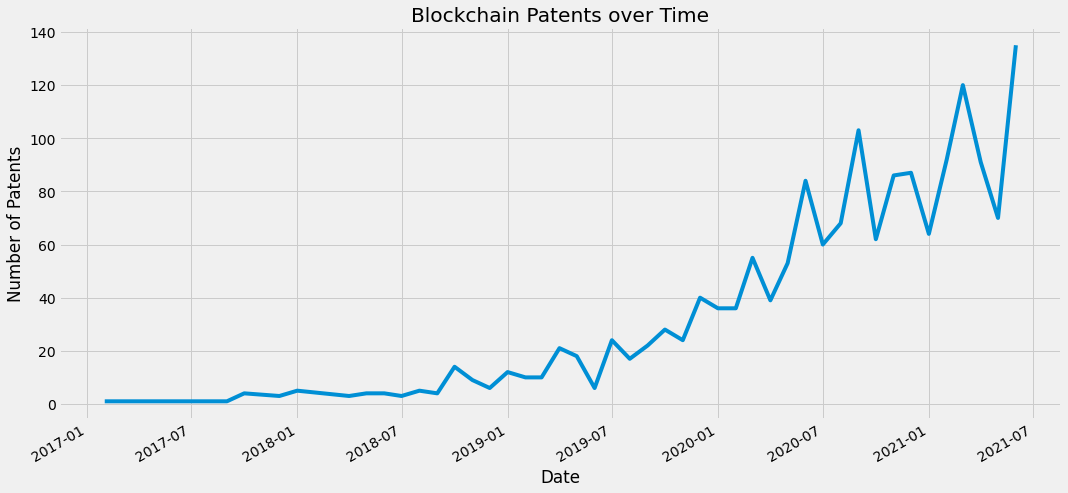

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.style.use('fivethirtyeight')

data['year-month'] = [
    pd.datetime(year, month, 1) for year, month in zip(
        data['patent_date'].dt.year, data['patent_date'].dt.month)]

month_group = data.groupby('year-month')['patent_number'].count().reset_index()

month_group.set_index('year-month')['patent_number'].plot(figsize=(16, 8))
plt.ylabel('Number of Patents')
plt.xlabel('Date')
plt.title('Blockchain Patents over Time')

In [ ]:
month_group.groupby(month_group['year-month'].dt.year)['patent_number'].sum().plot.bar(
    color='red', edgecolor='k', figsize=(12, 6))
plt.xlabel('Year')
plt.ylabel('Number of Patents')
plt.title('Neural Network Patents by Year')

# Keyword Analysis and Extraction

In [9]:
from wordcloud import WordCloud
import nltk
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [10]:
stopwords = nltk.corpus.stopwords.words('english')

In [11]:
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

In [12]:
def text_cleaner(text):
    newString = text.lower()
    newString = re.sub('"', '', newString)
    newString = re.sub(r'\([^)]*\)', '', newString)
    newString = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in newString.split(' ')])
    newString = re.sub(r"’s\b", "", newString)
    newString = re.sub('[^a-zA-Z\s\-]', '', newString)
    newString = re.sub('[^a-zA-Z\s]', ' ', newString)
    tokens = [w for w in newString.split() if w not in stopwords]
    long_words = []
    prev_word = []
    for i in tokens:
        if i not in prev_word and len(i) >= 3:  # removing short word
            long_words.append(i)
            prev_word = [i]
    return (" ".join(long_words)).strip()

In [13]:
def plot_wordcloud(year):
    per_year = data[data['patent_year'] == year]
    cleaned_text = per_year['patent_abstract'].apply(lambda x : text_cleaner(x))
    # Join the different processed texts together.
    long_string = ','.join(list(cleaned_text.values))
    # Create a WordCloud object
    wordcloud = WordCloud(background_color="white", max_words=1000, contour_width=3, contour_color='steelblue')
    # Generate a word cloud
    wordcloud.generate(long_string)
    # Visualize the word cloud
    return wordcloud.to_image()

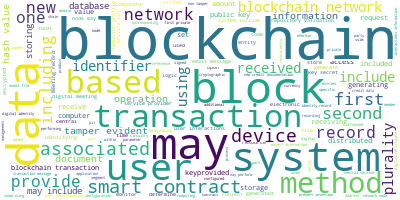

In [14]:
plot_wordcloud(2018)

In [15]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

In [16]:
data_year = data.groupby(['patent_year'])['patent_abstract'].apply(' '.join).reset_index()
data_year['abstract_clean'] = data_year['patent_abstract'].apply(lambda x : text_cleaner(x))

In [17]:
def sort_coo(coo_matrix):
    tuples = zip(coo_matrix.col, coo_matrix.data)
    return sorted(tuples, key=lambda x: (x[1], x[0]), reverse=True)

In [18]:
def extract_topn_from_vector(feature_names, sorted_items, topn=10):
    sorted_items = sorted_items[:topn]
    score_vals = []
    feature_vals = []

    for idx, score in sorted_items:
        fname = feature_names[idx]
        score_vals.append(round(score, 3))
        feature_vals.append(feature_names[idx])

    results = {}
    for idx in range(len(feature_vals)):
        results[feature_vals[idx]]=score_vals[idx]
    return results

In [19]:
def get_keywords(content_list):
  keywords = []

  cv = CountVectorizer(max_df = 0.85)
  word_count_vector = cv.fit_transform(content_list)

  tfidf_transformer = TfidfTransformer(smooth_idf=True,use_idf=True)
  tfidf_transformer.fit(word_count_vector)

  feature_names = cv.get_feature_names()

  for i in range(len(content_list)):
      doc = content_list[i]
      tf_idf_vector = tfidf_transformer.transform(cv.transform([doc]))
      sorted_items = sort_coo(tf_idf_vector.tocoo())
      keys = extract_topn_from_vector(feature_names,sorted_items,10)
      keywords.append(list(keys.keys()))
  
  return keywords

In [20]:
data_year = pd.concat([data_year, pd.Series(get_keywords(data_year['abstract_clean'].tolist()))], axis = 1)

In [21]:
data_year = data_year.rename(columns={0:"keywords"})

,patent_year,patent_abstract,abstract_clean,keywords
0,2017,The invention describes an identity management...,invention describes identity management system...,"[linket, identities, app, linkets, galois, vot..."
1,2018,A blockchain test configuration may provide a ...,blockchain test configuration may provide simp...,"[information, block, meeting, new, contract, m..."
2,2019,A balancing and control (B&C) system for API t...,balancing control system api transactions disc...,"[block, information, plurality, receiving, ser..."
3,2020,Using a blockchain transaction acceleration sy...,using blockchain transaction acceleration syst...,"[information, block, contract, plurality, meth..."
4,2021,Using a blockchain transaction acceleration sy...,using blockchain transaction acceleration syst...,"[information, block, target, plurality, servic..."


Some obvious keywords identified by Tf-idf include "information" and "block" but an interesting word that appears in several of the years is "plurality". Another is "contract" which aligns the application of blockchain in smart contracts due to the ledger framework.


In [23]:
data_year['keywords'].tolist()

[['linket',
  'identities',
  'app',
  'linkets',
  'galois',
  'voting',
  'rewrites',
  'link',
  'deep',
  'individually'],
 ['information',
  'block',
  'meeting',
  'new',
  'contract',
  'message',
  'plurality',
  'document',
  'amount',
  'storing'],
 ['block',
  'information',
  'plurality',
  'receiving',
  'service',
  'new',
  'access',
  'devices',
  'contract',
  'content'],
 ['information',
  'block',
  'contract',
  'plurality',
  'methods',
  'service',
  'nodes',
  'receiving',
  'determining',
  'server'],
 ['information',
  'block',
  'target',
  'plurality',
  'service',
  'nodes',
  'methods',
  'receiving',
  'computing',
  'contract']]